<a href="https://colab.research.google.com/github/StokedDude/crypto/blob/main/CANSLIM_Signal_Booster_V6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 CANSLIM Signal Booster V6

**Quantitative Framework for CANSLIM Stock Selection**

---

## What's New in V6

### Three High-Impact Upgrades

1. **🔧 True 52-Week High** (Fixed Bug)
   - V5: Used whatever data downloaded (often 6 months)
   - V6: Fetches true 252 trading days
   - Bonus: 20-day high for tight base detection

2. **📈 Relative Strength vs SPY/QQQ**
   - RS line slope (20-day + 60-day, annualized %)
   - RS new high before price (accumulation signal)
   - Quantified outperformance vs market

3. **📊 Volume Quality**
   - Volume Dry-Up (VDU) ratio (accumulation)
   - Breakout volume validation (1.5x+)
   - Up/Down volume ratio (buying pressure)

---

## Quick Start

1. **Upload MarketSurge CSV** (Section 2)
2. **Run all cells** (Runtime → Run all)
3. Get ranked stock list with V6 scores
4. Download results

**Total time**: 5-10 minutes

# Section 1: Installation

Install dependencies and set up environment.

In [9]:
# Install dependencies
!pip install -q yfinance pandas numpy matplotlib seaborn

print("✅ Installation complete!")
print("📊 Ready for stock screening...")

✅ Installation complete!
📊 Ready for stock screening...


# Section 2: Upload MarketSurge Data

Upload your MarketSurge CSV export here.

**Required columns:**
- Symbol
- EPS Growth (optional, for fundamental scoring)
- Sales Growth (optional)
- RS Rating (optional)

**Or just upload a simple CSV with a "Symbol" column.**

In [10]:
from google.colab import files
import pandas as pd
import io

print("📤 Upload your MarketSurge CSV file...\n")

uploaded = files.upload()

# Load the CSV
csv_filename = list(uploaded.keys())[0]
ms_df = pd.read_csv(io.BytesIO(uploaded[csv_filename]))

print(f"\n✅ Loaded {len(ms_df)} stocks")
print(f"\nColumns: {list(ms_df.columns)}")
print("\nFirst few rows:")
print(ms_df.head())

# Ensure we have a Symbol column
if 'Symbol' not in ms_df.columns:
    if 'symbol' in ms_df.columns:
        ms_df.rename(columns={'symbol': 'Symbol'}, inplace=True)
    elif 'Ticker' in ms_df.columns:
        ms_df.rename(columns={'Ticker': 'Symbol'}, inplace=True)
    else:
        print("\n⚠️  Warning: No 'Symbol' column found. Please ensure CSV has stock symbols.")

📤 Upload your MarketSurge CSV file...



Saving MarketSurge Growth 250.csv to MarketSurge Growth 250.csv

✅ Loaded 300 stocks

Columns: ['Order', 'Symbol', 'Name', 'Current Price', 'Price $ Chg', 'Price % Chg', '% Off High', 'Vol % Chg vs 50-Day', '50-Day Avg Vol (1000s)', '50-Day Avg $ Vol (1000s)', 'Market Cap (mil)', 'Comp Rating', 'EPS Rating', 'RS Rating', 'A/D Rating', 'SMR Rating', 'Ind Group Rank', 'Industry Name', 'IPO Date']

First few rows:
   Order Symbol                Name  Current Price  Price $ Chg  Price % Chg  \
0      1     MU   Micron Technology         414.88       -20.91        -4.80   
1      2   SNDK             Sandisk         576.25        36.95         6.85   
2      3    WDC     Western Digital         250.23       -28.18       -10.12   
3      4    STX  Seagate Technology         407.69       -38.88        -8.71   
4      5   LITE   Lumentum Holdings         391.84        10.40         2.73   

   % Off High  Vol % Chg vs 50-Day  50-Day Avg Vol (1000s)  \
0       -8.92                 63.2        

# Section 3: V6 Technical Scoring Engine

Complete V6 scoring system with all upgrades.

In [11]:
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA FETCHING (252 days for true 52-week high)
# ============================================================================

def fetch_extended_price_data(ticker, days=252):
    """Fetch 252 trading days for true 52-week calculations."""
    try:
        start_date = (datetime.now() - timedelta(days=int(days * 1.5))).strftime('%Y-%m-%d')
        data = yf.download(ticker, start=start_date, progress=False)
        if data.empty:
            return None
        return data.tail(days)
    except:
        return None

# ============================================================================
# UPGRADE 1: TRUE 52-WEEK HIGH
# ============================================================================

def calculate_52week_metrics(df):
    """Calculate true 52-week and 20-day high metrics."""
    if df is None or len(df) < 20:
        return {
            'high_52w': np.nan,
            'pct_from_52w': np.nan,
            'high_20d': np.nan,
            'pct_from_20d': np.nan
        }

    close = df['Close']
    high_52w = close.max()
    current_price = close.iloc[-1]
    pct_from_52w = (current_price / high_52w - 1.0) * 100

    high_20d = close.tail(20).max()
    pct_from_20d = (current_price / high_20d - 1.0) * 100

    return {
        'high_52w': high_52w,
        'pct_from_52w': pct_from_52w,
        'high_20d': high_20d,
        'pct_from_20d': pct_from_20d
    }

# ============================================================================
# UPGRADE 2: RELATIVE STRENGTH VS SPY
# ============================================================================

def calculate_slope(series, normalize=True):
    """Calculate slope with optional annualization."""
    if len(series) < 2:
        return 0
    series = series.dropna()
    if len(series) < 2:
        return 0

    x = np.arange(len(series))
    y = series.values
    slope, _ = np.polyfit(x, y, 1)

    if normalize and series.iloc[0] > 0:
        days = len(series)
        pct_change = (slope * days) / series.iloc[0]
        annualized = pct_change * (252 / days) * 100
        return annualized
    return slope

def detect_rs_leading_price(price, rs_line, lookback=60):
    """Detect if RS made new high while price consolidated."""
    if len(price) < lookback or len(rs_line) < lookback:
        return False

    price_recent = price.tail(lookback)
    rs_recent = rs_line.tail(lookback)

    rs_high_60d = rs_recent.max()
    rs_last_20d_high = rs_recent.tail(20).max()
    rs_new_high = (rs_last_20d_high >= rs_high_60d * 0.999)

    price_high_60d = price_recent.max()
    price_last_20d_high = price_recent.tail(20).max()
    price_new_high = (price_last_20d_high >= price_high_60d * 0.999)

    return rs_new_high and not price_new_high

def calculate_rs_line_metrics(stock_df, spy_df):
    """Calculate RS line metrics vs SPY."""
    if stock_df is None or spy_df is None:
        return {
            'rs_slope_20d': 0,
            'rs_slope_60d': 0,
            'rs_new_high_before_price': False,
            'rs_vs_spy_current': 0
        }

    common_idx = stock_df.index.intersection(spy_df.index)
    if len(common_idx) < 60:
        return {
            'rs_slope_20d': 0,
            'rs_slope_60d': 0,
            'rs_new_high_before_price': False,
            'rs_vs_spy_current': 0
        }

    stock_close = stock_df.loc[common_idx, 'Close']
    spy_close = spy_df.loc[common_idx, 'Close']
    rs_line = stock_close / spy_close

    rs_slope_20d = calculate_slope(rs_line.tail(20))
    rs_slope_60d = calculate_slope(rs_line.tail(60))
    rs_vs_spy_current = rs_line.iloc[-1]
    rs_new_high_before_price = detect_rs_leading_price(stock_close, rs_line)

    return {
        'rs_slope_20d': rs_slope_20d,
        'rs_slope_60d': rs_slope_60d,
        'rs_new_high_before_price': rs_new_high_before_price,
        'rs_vs_spy_current': rs_vs_spy_current
    }

# ============================================================================
# UPGRADE 3: VOLUME QUALITY
# ============================================================================

def calculate_vdu_ratio(close, volume, lookback=30):
    """Volume Dry-Up: down-volume vs up-volume."""
    if len(close) < lookback:
        return 1.0

    recent_close = close.tail(lookback)
    recent_volume = volume.tail(lookback)
    returns = recent_close.pct_change()

    up_volume = recent_volume[returns > 0].mean()
    down_volume = recent_volume[returns < 0].mean()

    if up_volume == 0 or pd.isna(up_volume):
        return 1.0

    vdu_ratio = down_volume / up_volume if not pd.isna(down_volume) else 1.0
    return vdu_ratio

def calculate_updown_volume_ratio(close, volume, lookback=20):
    """Up/Down volume ratio."""
    if len(close) < lookback:
        return 1.0

    recent_close = close.tail(lookback)
    recent_volume = volume.tail(lookback)
    returns = recent_close.pct_change()

    up_volume = recent_volume[returns > 0].sum()
    down_volume = recent_volume[returns < 0].sum()

    if down_volume == 0:
        return 2.0

    ratio = up_volume / down_volume
    return min(ratio, 2.0)

def calculate_volume_metrics(df):
    """Calculate volume quality metrics."""
    if df is None or len(df) < 50:
        return {
            'vdu_ratio': 0,
            'breakout_volume_ratio': 0,
            'updown_volume_ratio': 1.0,
            'avg_volume_50d': 0
        }

    close = df['Close']
    volume = df['Volume']

    avg_volume_50d = volume.tail(50).mean()
    vdu_ratio = calculate_vdu_ratio(close, volume, lookback=30)
    recent_volume = volume.tail(5).mean()
    breakout_volume_ratio = recent_volume / avg_volume_50d if avg_volume_50d > 0 else 0
    updown_volume_ratio = calculate_updown_volume_ratio(close, volume, lookback=20)

    return {
        'vdu_ratio': vdu_ratio,
        'breakout_volume_ratio': breakout_volume_ratio,
        'updown_volume_ratio': updown_volume_ratio,
        'avg_volume_50d': avg_volume_50d
    }

# ============================================================================
# V6 TECHNICAL SCORE
# ============================================================================

def calculate_technical_score_v6(ticker, spy_df):
    """Calculate V6 technical score (0-100)."""
    df = fetch_extended_price_data(ticker)

    if df is None or len(df) < 60:
        return {
            'technical_score': 0,
            'breakdown': {},
            'error': 'Insufficient data'
        }

    high_metrics = calculate_52week_metrics(df)
    rs_metrics = calculate_rs_line_metrics(df, spy_df)
    vol_metrics = calculate_volume_metrics(df)

    # COMPONENT 1: PRICE ACTION (25 points)
    pct_from_52w = high_metrics['pct_from_52w']
    if pct_from_52w > -15:
        high_52w_score = 10
    elif pct_from_52w > -50:
        high_52w_score = 10 * (1 - (abs(pct_from_52w) - 15) / 35)
    else:
        high_52w_score = 0

    pct_from_20d = high_metrics['pct_from_20d']
    if pct_from_20d > -5:
        high_20d_score = 10
    elif pct_from_20d > -15:
        high_20d_score = 10 * (1 - (abs(pct_from_20d) - 5) / 10)
    else:
        high_20d_score = 0

    close = df['Close'].iloc[-1]
    sma_20 = df['Close'].tail(20).mean()
    sma_50 = df['Close'].tail(50).mean()
    above_sma_score = (2.5 if close > sma_20 else 0) + (2.5 if close > sma_50 else 0)

    price_score = high_52w_score + high_20d_score + above_sma_score

    # COMPONENT 2: RELATIVE STRENGTH (30 points)
    rs_slope_20 = rs_metrics['rs_slope_20d']
    rs_20_score = np.clip(rs_slope_20 / 5, 0, 10)

    rs_slope_60 = rs_metrics['rs_slope_60d']
    rs_60_score = np.clip(rs_slope_60 / 5, 0, 10)

    rs_leading_score = 10 if rs_metrics['rs_new_high_before_price'] else 0
    rs_score = rs_20_score + rs_60_score + rs_leading_score

    # COMPONENT 3: VOLUME QUALITY (25 points)
    vdu = vol_metrics['vdu_ratio']
    if vdu <= 0.5:
        vdu_score = 10
    elif vdu < 1.0:
        vdu_score = 10 * (1 - (vdu - 0.5) / 0.5)
    else:
        vdu_score = 0

    breakout_vol = vol_metrics['breakout_volume_ratio']
    if breakout_vol >= 1.5:
        breakout_score = 10
    elif breakout_vol >= 1.0:
        breakout_score = 10 * (breakout_vol - 1.0) / 0.5
    else:
        breakout_score = 0

    updown_ratio = vol_metrics['updown_volume_ratio']
    if updown_ratio >= 1.3:
        updown_score = 5
    elif updown_ratio >= 1.0:
        updown_score = 5 * (updown_ratio - 1.0) / 0.3
    else:
        updown_score = 0

    volume_score = vdu_score + breakout_score + updown_score

    # COMPONENT 4: MOMENTUM (20 points)
    ret_20d = (df['Close'].iloc[-1] / df['Close'].iloc[-20] - 1) * 100
    mom_20_score = np.clip(ret_20d / 10, 0, 10) if ret_20d > 0 else 0

    if len(df) >= 60:
        ret_60d = (df['Close'].iloc[-1] / df['Close'].iloc[-60] - 1) * 100
        mom_60_score = np.clip(ret_60d / 20, 0, 10) if ret_60d > 0 else 0
    else:
        ret_60d = None
        mom_60_score = 0

    momentum_score = mom_20_score + mom_60_score

    # TOTAL SCORE
    total_score = price_score + rs_score + volume_score + momentum_score

    breakdown = {
        'price_action': round(price_score, 1),
        'relative_strength': round(rs_score, 1),
        'volume_quality': round(volume_score, 1),
        'momentum': round(momentum_score, 1),
        'pct_from_52w': round(pct_from_52w, 2),
        'pct_from_20d': round(pct_from_20d, 2),
        'rs_slope_20d': round(rs_slope_20, 2),
        'rs_slope_60d': round(rs_slope_60, 2),
        'rs_leading_price': rs_metrics['rs_new_high_before_price'],
        'vdu_ratio': round(vdu, 3),
        'breakout_volume': round(breakout_vol, 2),
        'updown_volume_ratio': round(updown_ratio, 2),
        'return_20d': round(ret_20d, 2),
        'return_60d': round(ret_60d, 2) if ret_60d else None,
    }

    return {
        'technical_score': round(total_score, 1),
        'breakdown': breakdown
    }

print("✅ V6 scoring engine loaded")
print("📊 Ready to analyze stocks")

✅ V6 scoring engine loaded
📊 Ready to analyze stocks


# Section 4: Fetch Benchmark Data

Download SPY for RS calculations (done once, reused for all stocks).

In [12]:
print("📥 Fetching SPY benchmark data...\n")

start_date = (datetime.now() - timedelta(days=int(252 * 1.5))).strftime('%Y-%m-%d')
spy_df = yf.download('SPY', start=start_date, progress=False)

if not spy_df.empty:
    spy_df = spy_df.tail(252)
    print(f"✅ SPY data loaded")
    print(f"   Period: {spy_df.index[0].date()} to {spy_df.index[-1].date()}")
    print(f"   Days: {len(spy_df)}")
else:
    print("⚠️  Warning: Could not load SPY data. RS metrics will be unavailable.")
    spy_df = None

📥 Fetching SPY benchmark data...

✅ SPY data loaded
   Period: 2025-01-30 to 2026-01-30
   Days: 252


# Section 5: Score All Stocks

Add V6 technical scores to your MarketSurge data.

In [13]:
print("🔄 Analyzing stocks with V6 scoring...\n")
print(f"Total stocks: {len(ms_df)}")
print("\nProgress: ", end="", flush=True)

# Add V6 columns
ms_df['Tech_Score_V6'] = 0.0
ms_df['Price_Action'] = 0.0
ms_df['Relative_Strength'] = 0.0
ms_df['Volume_Quality'] = 0.0
ms_df['Momentum'] = 0.0
ms_df['From_52w_High'] = 0.0
ms_df['From_20d_High'] = 0.0
ms_df['RS_Slope_20d'] = 0.0
ms_df['RS_Leading'] = False
ms_df['VDU_Ratio'] = 0.0
ms_df['Breakout_Volume'] = 0.0

# Score each stock
for idx, row in ms_df.iterrows():
    ticker = row['Symbol']

    if idx % 10 == 0:
        print(".", end="", flush=True)

    try:
        result = calculate_technical_score_v6(ticker, spy_df)

        if 'error' not in result:
            bd = result['breakdown']

            ms_df.loc[idx, 'Tech_Score_V6'] = result['technical_score']
            ms_df.loc[idx, 'Price_Action'] = bd['price_action']
            ms_df.loc[idx, 'Relative_Strength'] = bd['relative_strength']
            ms_df.loc[idx, 'Volume_Quality'] = bd['volume_quality']
            ms_df.loc[idx, 'Momentum'] = bd['momentum']
            ms_df.loc[idx, 'From_52w_High'] = bd['pct_from_52w']
            ms_df.loc[idx, 'From_20d_High'] = bd['pct_from_20d']
            ms_df.loc[idx, 'RS_Slope_20d'] = bd['rs_slope_20d']
            ms_df.loc[idx, 'RS_Leading'] = bd['rs_leading_price']
            ms_df.loc[idx, 'VDU_Ratio'] = bd['vdu_ratio']
            ms_df.loc[idx, 'Breakout_Volume'] = bd['breakout_volume']

    except Exception as e:
        print(f"\n⚠️  Error with {ticker}: {str(e)[:50]}")
        continue

print("\n\n✅ Scoring complete!")

# Sort by technical score
ms_df = ms_df.sort_values('Tech_Score_V6', ascending=False)

print(f"\n📊 Top 10 by V6 Technical Score:")
print("=" * 80)
top10 = ms_df[['Symbol', 'Tech_Score_V6', 'From_52w_High', 'RS_Leading', 'VDU_Ratio']].head(10)
print(top10.to_string(index=False))
print("=" * 80)

🔄 Analyzing stocks with V6 scoring...

Total stocks: 300

Progress: .
⚠️  Error with MU: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with SNDK: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with WDC: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with STX: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with LITE: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with VIAV: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with CIEN: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with AAOI: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with NEM: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with B: The truth value of a Series is ambiguous. Use a.em
.
⚠️  Error with AEM: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with CDE: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with KGC: The truth value of a Series is ambiguous. U

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MOGA']: YFTzMissingError('possibly delisted; no timezone found')



⚠️  Error with AIR: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with FTAI: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with KTOS: The truth value of a Series is ambiguous. Use a.em
.
⚠️  Error with CW: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with MRCY: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with ATRO: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with GE: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with HWM: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with CRS: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with ATI: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with HII: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with EMBJ: The truth value of a Series is ambiguous. Use a.em

⚠️  Error with RTX: The truth value of a Series is ambiguous. Use a.em
.
⚠️  Error with BA: The truth value of a Series is ambiguou

# Section 6: Detailed Analysis

View detailed breakdown for top stocks.

In [14]:
print("📈 DETAILED V6 BREAKDOWN - TOP 5 STOCKS")
print("=" * 80)

top5 = ms_df.head(5)

for idx, row in top5.iterrows():
    print(f"\n{row['Symbol']} - Score: {row['Tech_Score_V6']:.1f}/100")
    print("-" * 80)

    print(f"\n  COMPONENT SCORES:")
    print(f"    Price Action:       {row['Price_Action']:.1f}/25")
    print(f"    Relative Strength:  {row['Relative_Strength']:.1f}/30")
    print(f"    Volume Quality:     {row['Volume_Quality']:.1f}/25")
    print(f"    Momentum:           {row['Momentum']:.1f}/20")

    print(f"\n  KEY METRICS:")
    print(f"    From 52w high:      {row['From_52w_High']:.1f}%")
    print(f"    From 20d high:      {row['From_20d_High']:.1f}%")
    print(f"    RS slope (20d):     {row['RS_Slope_20d']:.1f}%")
    print(f"    RS leading price:   {'✅ YES' if row['RS_Leading'] else 'No'}")
    print(f"    VDU ratio:          {row['VDU_Ratio']:.2f} (lower = better)")
    print(f"    Breakout volume:    {row['Breakout_Volume']:.2f}x")

    # Interpretation
    if row['Tech_Score_V6'] >= 80:
        rating = "🟢 STRONG SETUP"
    elif row['Tech_Score_V6'] >= 60:
        rating = "🟡 DECENT SETUP"
    else:
        rating = "🔴 WEAK SETUP"

    print(f"\n  RATING: {rating}")
    print("=" * 80)

📈 DETAILED V6 BREAKDOWN - TOP 5 STOCKS

ABBNY - Score: 0.0/100
--------------------------------------------------------------------------------

  COMPONENT SCORES:
    Price Action:       0.0/25
    Relative Strength:  0.0/30
    Volume Quality:     0.0/25
    Momentum:           0.0/20

  KEY METRICS:
    From 52w high:      0.0%
    From 20d high:      0.0%
    RS slope (20d):     0.0%
    RS leading price:   No
    VDU ratio:          0.00 (lower = better)
    Breakout volume:    0.00x

  RATING: 🔴 WEAK SETUP

MU - Score: 0.0/100
--------------------------------------------------------------------------------

  COMPONENT SCORES:
    Price Action:       0.0/25
    Relative Strength:  0.0/30
    Volume Quality:     0.0/25
    Momentum:           0.0/20

  KEY METRICS:
    From 52w high:      0.0%
    From 20d high:      0.0%
    RS slope (20d):     0.0%
    RS leading price:   No
    VDU ratio:          0.00 (lower = better)
    Breakout volume:    0.00x

  RATING: 🔴 WEAK SETUP

SND

# Section 7: Filter by Criteria

Apply filters to find best setups.

In [15]:
print("🔍 FILTERING FOR HIGH-QUALITY SETUPS\n")

# Define filters
filtered = ms_df[
    (ms_df['Tech_Score_V6'] >= 70) &          # Strong technical score
    (ms_df['From_52w_High'] > -20) &          # Within 20% of 52w high
    (ms_df['RS_Slope_20d'] > 0) &             # Outperforming SPY
    (ms_df['VDU_Ratio'] < 0.8)                # Accumulation pattern
].copy()

print(f"Found {len(filtered)} stocks matching criteria:\n")
print("Filters applied:")
print("  ✓ Tech Score ≥ 70")
print("  ✓ Within 20% of 52-week high")
print("  ✓ RS slope > 0 (outperforming SPY)")
print("  ✓ VDU < 0.8 (accumulation)")

if len(filtered) > 0:
    print(f"\n{'='*80}")
    print("QUALIFIED STOCKS:")
    print("="*80)

    display_cols = [
        'Symbol', 'Tech_Score_V6', 'From_52w_High',
        'RS_Slope_20d', 'RS_Leading', 'VDU_Ratio'
    ]
    print(filtered[display_cols].to_string(index=False))
    print("="*80)
else:
    print("\n⚠️  No stocks match all criteria. Try relaxing filters.")

🔍 FILTERING FOR HIGH-QUALITY SETUPS

Found 0 stocks matching criteria:

Filters applied:
  ✓ Tech Score ≥ 70
  ✓ Within 20% of 52-week high
  ✓ RS slope > 0 (outperforming SPY)
  ✓ VDU < 0.8 (accumulation)

⚠️  No stocks match all criteria. Try relaxing filters.


# Section 8: Export Results

Download your ranked stock list.

In [17]:
from datetime import datetime

# Create export filename
export_filename = f"canslim_v6_results_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"

# Export all results
ms_df.to_csv(export_filename, index=False)

print("💾 EXPORT COMPLETE\n")
print(f"File: {export_filename}")
print(f"Rows: {len(ms_df)}")
print(f"\nDownloading...")

# Download
files.download(export_filename)

print("\n✅ File downloaded!")
print("\nColumns included:")
print("  - Original MarketSurge data")
print("  - Tech_Score_V6 (0-100)")
print("  - Component scores (Price/RS/Volume/Momentum)")
print("  - All V6 metrics")

💾 EXPORT COMPLETE

File: canslim_v6_results_20260201_1753.csv
Rows: 300

Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ File downloaded!

Columns included:
  - Original MarketSurge data
  - Tech_Score_V6 (0-100)
  - Component scores (Price/RS/Volume/Momentum)
  - All V6 metrics


# Section 9: Quick Stats

Summary statistics for your universe.

📊 V6 SCORING STATISTICS

Total stocks analyzed:     300
Average V6 score:          0.0
Median V6 score:           0.0

Score distribution:
  80-100 (Strong):         0 stocks
  60-79  (Decent):         0 stocks
  <60    (Weak):           300 stocks

RS Leading Price signals: 0 stocks
Near 52w highs (<5%):     300 stocks
Tight bases (<5% 20d):    300 stocks


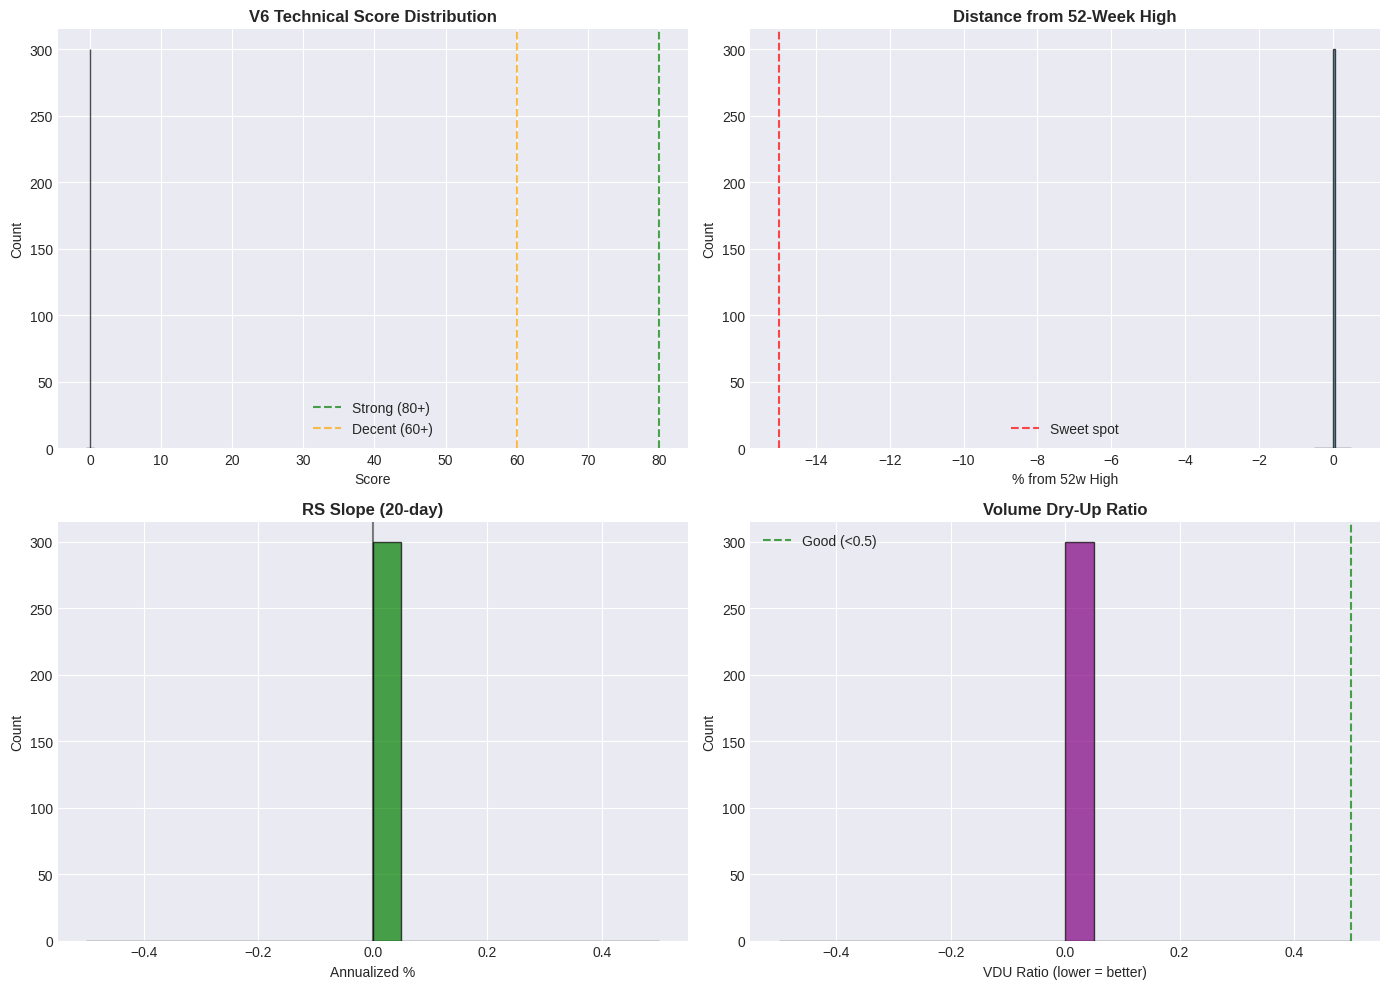

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')

print("📊 V6 SCORING STATISTICS\n")
print("="*80)

# Overall stats
print(f"Total stocks analyzed:     {len(ms_df)}")
print(f"Average V6 score:          {ms_df['Tech_Score_V6'].mean():.1f}")
print(f"Median V6 score:           {ms_df['Tech_Score_V6'].median():.1f}")
print(f"\nScore distribution:")
print(f"  80-100 (Strong):         {len(ms_df[ms_df['Tech_Score_V6'] >= 80])} stocks")
print(f"  60-79  (Decent):         {len(ms_df[(ms_df['Tech_Score_V6'] >= 60) & (ms_df['Tech_Score_V6'] < 80)])} stocks")
print(f"  <60    (Weak):           {len(ms_df[ms_df['Tech_Score_V6'] < 60])} stocks")

print(f"\nRS Leading Price signals: {ms_df['RS_Leading'].sum()} stocks")
print(f"Near 52w highs (<5%):     {len(ms_df[ms_df['From_52w_High'] > -5])} stocks")
print(f"Tight bases (<5% 20d):    {len(ms_df[ms_df['From_20d_High'] > -5])} stocks")

# Histogram
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score distribution
axes[0, 0].hist(ms_df['Tech_Score_V6'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('V6 Technical Score Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(80, color='green', linestyle='--', alpha=0.7, label='Strong (80+)')
axes[0, 0].axvline(60, color='orange', linestyle='--', alpha=0.7, label='Decent (60+)')
axes[0, 0].legend()

# Distance from 52w high
axes[0, 1].hist(ms_df['From_52w_High'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('Distance from 52-Week High', fontweight='bold')
axes[0, 1].set_xlabel('% from 52w High')
axes[0, 1].set_ylabel('Count')
axes[0, 1].axvline(-15, color='red', linestyle='--', alpha=0.7, label='Sweet spot')
axes[0, 1].legend()

# RS Slope
axes[1, 0].hist(ms_df['RS_Slope_20d'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('RS Slope (20-day)', fontweight='bold')
axes[1, 0].set_xlabel('Annualized %')
axes[1, 0].set_ylabel('Count')
axes[1, 0].axvline(0, color='black', linestyle='-', alpha=0.5)

# VDU Ratio
axes[1, 1].hist(ms_df['VDU_Ratio'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Volume Dry-Up Ratio', fontweight='bold')
axes[1, 1].set_xlabel('VDU Ratio (lower = better)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].axvline(0.5, color='green', linestyle='--', alpha=0.7, label='Good (<0.5)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)

# Section 10: Next Steps

What to do with your results.

In [19]:
print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                    🎯 NEXT STEPS WITH V6 RESULTS                           ║
╚════════════════════════════════════════════════════════════════════════════╝

✅ You've completed V6 technical scoring!

═══════════════════════════════════════════════════════════════════════════
IMMEDIATE (This Week)
═══════════════════════════════════════════════════════════════════════════

1. Review Top Stocks
   □ Focus on Tech_Score_V6 ≥ 70
   □ Look for RS_Leading = True (accumulation)
   □ Check VDU_Ratio < 0.6 (volume confirms)

2. Manual Validation
   □ Check top 10 in TradingView
   □ Verify RS line visually
   □ Confirm volume patterns in ToS
   □ Do V6 scores match your judgment?

3. Integration with Personal CIO
   □ Check market regime (run CIO Colab)
   □ If OFF → Skip all signals
   □ If LIGHT → Take top 3-5 only
   □ If ON → Take top 8-10

═══════════════════════════════════════════════════════════════════════════
SUNDAY ROUTINE
═══════════════════════════════════════════════════════════════════════════

1. Run Personal CIO (2 min)
   → Get regime state

2. Export MarketSurge (2 min)
   → Your fundamental screen

3. Run This Notebook (5 min)
   → Upload CSV
   → Runtime → Run all
   → Download results

4. Review & Select (3 min)
   → Check top stocks
   → Apply regime filter
   → Queue orders

═══════════════════════════════════════════════════════════════════════════
UNDERSTANDING V6 METRICS
═══════════════════════════════════════════════════════════════════════════

Tech_Score_V6 (0-100):
  80-100 = Strong setup, high conviction
  60-79  = Decent setup, selective
  <60    = Weak, skip

RS_Leading = True:
  ⭐ Classic CANSLIM accumulation tell
  RS making new highs while price consolidates
  Institutional buying before breakout

VDU_Ratio:
  <0.5  = Strong accumulation
  0.5-0.8 = Decent
  >0.8  = Weak (down volume not contracting)

From_52w_High:
  >-5%  = At highs (tight base possible)
  -5 to -15% = Sweet spot
  <-30% = Too far from highs

═══════════════════════════════════════════════════════════════════════════
V6 VS MANUAL ANALYSIS
═══════════════════════════════════════════════════════════════════════════

V6 automates what you do manually:
  ✓ RS line analysis → RS_Slope_20d
  ✓ RS leading price → RS_Leading flag
  ✓ Volume dry-up → VDU_Ratio
  ✓ Breakout volume → Breakout_Volume
  ✓ Distance from highs → From_52w_High (fixed!)

Same analysis, just:
  - Quantified (0-100 scores)
  - Scalable (entire universe)
  - Consistent (no bias)
  - Fast (minutes vs hours)

═══════════════════════════════════════════════════════════════════════════
COMMON PATTERNS TO LOOK FOR
═══════════════════════════════════════════════════════════════════════════

Perfect Setup:
  Tech_Score ≥ 80
  RS_Leading = True
  VDU_Ratio < 0.5
  From_52w_High > -10%
  → HIGH CONVICTION if regime ON

Tight Base:
  From_20d_High > -5%
  VDU_Ratio < 0.6
  Breakout_Volume > 1.5x
  → Ready for breakout

Relative Strength Leader:
  RS_Slope_20d > 30%
  RS_Leading = True
  → Outperforming market significantly

═══════════════════════════════════════════════════════════════════════════
WARNINGS
═══════════════════════════════════════════════════════════════════════════

❌ Don't ignore regime (Personal CIO)
❌ Don't trade high V6 scores in OFF regime
❌ Don't skip manual validation on top picks
❌ Don't forget stops at 7-8%

═══════════════════════════════════════════════════════════════════════════

🏔️  V6 = Your TradingView/ToS analysis, automated.

Same metrics you trust.
Just quantified and scaled.

╚════════════════════════════════════════════════════════════════════════════╝
""")


╔════════════════════════════════════════════════════════════════════════════╗
║                    🎯 NEXT STEPS WITH V6 RESULTS                           ║
╚════════════════════════════════════════════════════════════════════════════╝

✅ You've completed V6 technical scoring!

═══════════════════════════════════════════════════════════════════════════
IMMEDIATE (This Week)
═══════════════════════════════════════════════════════════════════════════

1. Review Top Stocks
   □ Focus on Tech_Score_V6 ≥ 70
   □ Look for RS_Leading = True (accumulation)
   □ Check VDU_Ratio < 0.6 (volume confirms)

2. Manual Validation
   □ Check top 10 in TradingView
   □ Verify RS line visually
   □ Confirm volume patterns in ToS
   □ Do V6 scores match your judgment?

3. Integration with Personal CIO
   □ Check market regime (run CIO Colab)
   □ If OFF → Skip all signals
   □ If LIGHT → Take top 3-5 only
   □ If ON → Take top 8-10

════════════════════════════════════════════════════════════════════════